In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
import pickle

In [3]:
image_size = (72, 72)
input_shape = (72, 72, 3)


train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    'Plant',
    validation_split=0.2,
    subset='training',
    seed=42,
    image_size=image_size,
    batch_size=1,
    label_mode='categorical'
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    'Plant',
    validation_split=0.2,
    subset='validation',
    seed=42,
    image_size=image_size,
    batch_size=1,
    label_mode='categorical'
)

Found 2152 files belonging to 3 classes.
Using 1722 files for training.
Found 2152 files belonging to 3 classes.
Using 430 files for validation.


In [4]:
# Training data
X_train, y_train = [], []
for image, label in train_ds:
    X_train.append(image)
    y_train.append(np.array(label))
X_train = np.array(X_train, dtype=np.uint8)
X_train = X_train.reshape((X_train.shape[0],) + input_shape)
y_train = np.array(y_train)
y_train = y_train.reshape((y_train.shape[0],) + (y_train.shape[-1],))

# Validation data
X_val, y_val = [], []
for image, label in val_ds:
    X_val.append(image)
    y_val.append(np.array(label))
X_val = np.array(X_val, dtype=np.uint8)
X_val= X_val.reshape((X_val.shape[0],) + input_shape)
y_val = np.array(y_val)
y_val = y_val.reshape((y_val.shape[0],) + (y_val.shape[-1],))

print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'X_val shape: {X_val.shape}')
print(f'y_val shape: {y_val.shape}')

X_train shape: (1722, 72, 72, 3)
y_train shape: (1722, 3)
X_val shape: (430, 72, 72, 3)
y_val shape: (430, 3)


C:\Users\user\anaconda3\lib\site-packages\matplotlib\text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


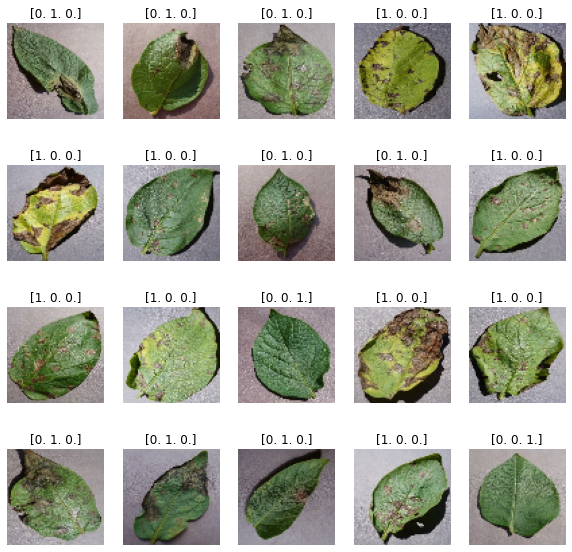

In [5]:
fig, axes = plt.subplots(4, 5, figsize=(10, 10))
for image, label, ax in zip(X_train, y_train, axes.flatten()):
    ax.imshow(image)
    ax.set_title(label)
    ax.set_axis_off()
plt.savefig('sample_training_data.png')

### Models

In [6]:
def load_pretrained_models(input_shape):
    
    all_models = {
        'xception': {
            'model': keras.applications.Xception(include_top=False, input_shape=input_shape),
            'preprocess': keras.applications.xception.preprocess_input,
        },
        'vgg16': {
            'model': keras.applications.VGG16(include_top=False, input_shape=input_shape),
            'preprocess': keras.applications.vgg16.preprocess_input,
        },
        'resnet50': {
            'model': keras.applications.ResNet50(include_top=False, input_shape=input_shape),
            'preprocess': keras.applications.resnet.preprocess_input,
        },
    }
    return all_models


all_models = load_pretrained_models(input_shape)

In [7]:
def make_model(input_shape, num_classes):
   
    inputs = keras.Input(shape=input_shape)
    x = layers.Flatten()(inputs)
    outputs = layers.Dense(
        num_classes,
        activation='softmax' if num_classes > 1 else 'sigmoid',
    )(x)

    model = keras.Model(inputs, outputs)
    return model

In [8]:
def fit_model(all_models, model_name, X_train, y_train, X_val, y_val, num_classes=3, batch_size=32):
   
    premodel = all_models[model_name]['model']
    preprocess = all_models[model_name]['preprocess']
    # use the output shape of the premodel as the input shape of our own model
    model = make_model(premodel.output.shape[1:], num_classes)
    # Create new training data
    X_train_pretrained = premodel.predict(preprocess(X_train))
    train_ds_pretrained = tf.data.Dataset.from_tensor_slices(
        (X_train_pretrained, y_train),
    ).batch(batch_size)
    # Create new validation data
    X_val_pretrained = premodel.predict(preprocess(X_val))
    val_ds_pretrained = tf.data.Dataset.from_tensor_slices(
        (X_val_pretrained, y_val),
    ).batch(batch_size)
    # fit model
    epochs = 50
    model.compile(
        optimizer=keras.optimizers.Adam(1e-3),
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )
    history = model.fit(
        train_ds_pretrained,
        epochs=epochs,
        callbacks=[
            keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta=0.01, patience=10, verbose=1, mode='auto')
        ],
        validation_data=val_ds_pretrained,
    )
    return model, history

In [18]:
def plot_loss_acc(history, file_name=''):
  
    SMALL_SIZE = 10
    MEDIUM_SIZE = 20
    LARGE_SIZE = 30

    # plt.rc('font', size=LARGE_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=LARGE_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=LARGE_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=LARGE_SIZE)  # fontsize of the figure title

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(30, 10))
    epochs = np.arange(1, len(history['loss']) + 1)
    
    ax1.plot(epochs, history['loss'], label='Train')
    ax1.plot(epochs, history['val_loss'], label='Validate')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Loss')
    ax1.legend(loc="upper right")

    ax2.plot(epochs, history['accuracy'], label='Train')
    ax2.plot(epochs, history['val_accuracy'], label='Validate')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('Accuracy')
    ax2.legend(loc="upper left")
    plt.tight_layout()
    if file_name:
        plt.savefig(file_name)
    else:
        plt.show()

In [10]:
model_xception, history_xception = fit_model(all_models, 'xception', X_train, y_train, X_val, y_val)

Epoch 1/50
54/54 [==============================] - 1s 6ms/step - loss: 0.5968 - accuracy: 0.8566 - val_loss: 0.3128 - val_accuracy: 0.9093
Epoch 2/50
54/54 [==============================] - 0s 4ms/step - loss: 0.1512 - accuracy: 0.9454 - val_loss: 0.1984 - val_accuracy: 0.9419
Epoch 3/50
54/54 [==============================] - 0s 4ms/step - loss: 0.0917 - accuracy: 0.9675 - val_loss: 0.3052 - val_accuracy: 0.9140
Epoch 4/50
54/54 [==============================] - 0s 4ms/step - loss: 0.0554 - accuracy: 0.9814 - val_loss: 0.3662 - val_accuracy: 0.9116
Epoch 5/50
54/54 [==============================] - 0s 4ms/step - loss: 0.0548 - accuracy: 0.9756 - val_loss: 0.4698 - val_accuracy: 0.8860
Epoch 6/50
54/54 [==============================] - 0s 4ms/step - loss: 0.0600 - accuracy: 0.9750 - val_loss: 0.3393 - val_accuracy: 0.9302
Epoch 7/50
54/54 [==============================] - 0s 4ms/step - loss: 0.0980 - accuracy: 0.9692 - val_loss: 0.4482 - val_accuracy: 0.9140
Epoch 8/50
54/54 [==

In [11]:
model_vgg16, history_vgg16 = fit_model(all_models, 'vgg16', X_train, y_train, X_val, y_val)

Epoch 1/50
54/54 [==============================] - 0s 3ms/step - loss: 1.5285 - accuracy: 0.7997 - val_loss: 0.8101 - val_accuracy: 0.8744
Epoch 2/50
54/54 [==============================] - 0s 1ms/step - loss: 0.4823 - accuracy: 0.9117 - val_loss: 0.5488 - val_accuracy: 0.9093
Epoch 3/50
54/54 [==============================] - 0s 1ms/step - loss: 0.2031 - accuracy: 0.9477 - val_loss: 0.5065 - val_accuracy: 0.9140
Epoch 4/50
54/54 [==============================] - 0s 1ms/step - loss: 0.0914 - accuracy: 0.9721 - val_loss: 0.5022 - val_accuracy: 0.9070
Epoch 5/50
54/54 [==============================] - 0s 1ms/step - loss: 0.0571 - accuracy: 0.9849 - val_loss: 0.4905 - val_accuracy: 0.9116
Epoch 6/50
54/54 [==============================] - 0s 1ms/step - loss: 0.0331 - accuracy: 0.9919 - val_loss: 0.4687 - val_accuracy: 0.9163
Epoch 7/50
54/54 [==============================] - 0s 1ms/step - loss: 0.0205 - accuracy: 0.9965 - val_loss: 0.4570 - val_accuracy: 0.9233
Epoch 8/50
54/54 [==

In [12]:
model_resnet50, history_resnet50 = fit_model(all_models, 'resnet50', X_train, y_train, X_val, y_val)

Epoch 1/50
54/54 [==============================] - 0s 5ms/step - loss: 0.7288 - accuracy: 0.8780 - val_loss: 0.2741 - val_accuracy: 0.9535
Epoch 2/50
54/54 [==============================] - 0s 4ms/step - loss: 0.1020 - accuracy: 0.9715 - val_loss: 0.2745 - val_accuracy: 0.9419
Epoch 3/50
54/54 [==============================] - 0s 4ms/step - loss: 0.0265 - accuracy: 0.9925 - val_loss: 0.2049 - val_accuracy: 0.9581
Epoch 4/50
54/54 [==============================] - 0s 4ms/step - loss: 0.0142 - accuracy: 0.9948 - val_loss: 0.1906 - val_accuracy: 0.9651
Epoch 5/50
54/54 [==============================] - 0s 4ms/step - loss: 0.0079 - accuracy: 0.9965 - val_loss: 0.2193 - val_accuracy: 0.9698
Epoch 6/50
54/54 [==============================] - 0s 4ms/step - loss: 0.0047 - accuracy: 0.9977 - val_loss: 0.2468 - val_accuracy: 0.9651
Epoch 7/50
54/54 [==============================] - 0s 4ms/step - loss: 0.0026 - accuracy: 1.0000 - val_loss: 0.1630 - val_accuracy: 0.9721
Epoch 8/50
54/54 [==

In [13]:
model_resnet50.save('Potato_Disease_Classification_model-FP')

INFO:tensorflow:Assets written to: Potato_Disease_Classification_model-FP\assets


In [14]:
model_xception.save('Potato_Disease_Classification_model-XC')

INFO:tensorflow:Assets written to: Potato_Disease_Classification_model-XC\assets


### Xception Model

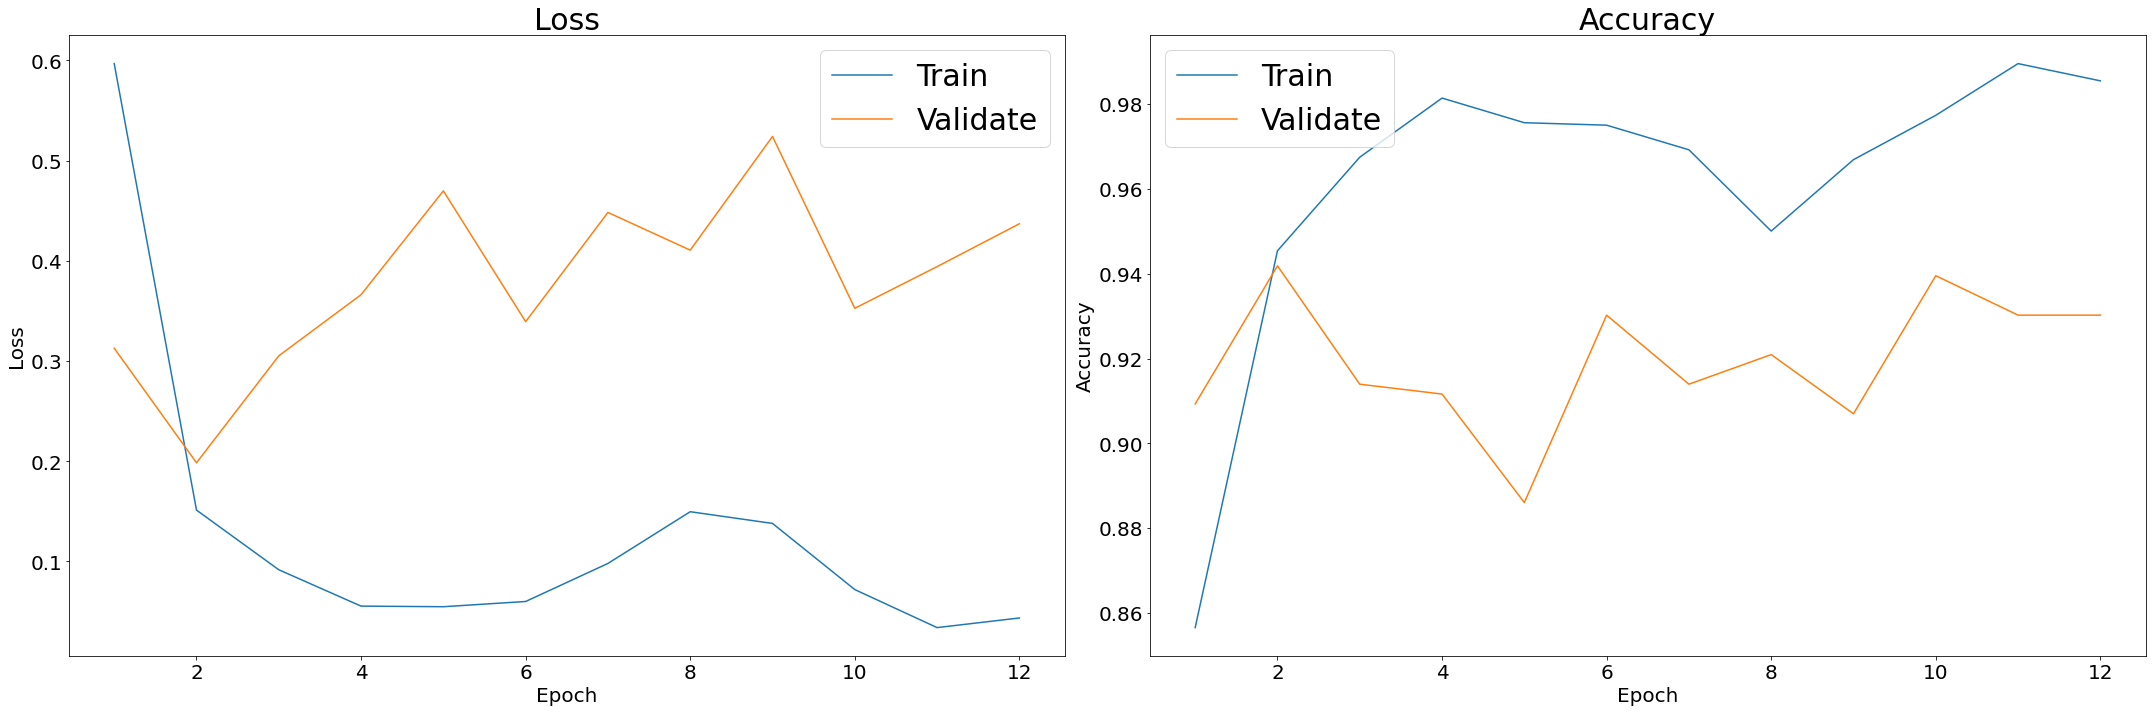

In [19]:
plot_loss_acc(history_xception.history, 'xception_loss_acc.png')

### VGG16 Model

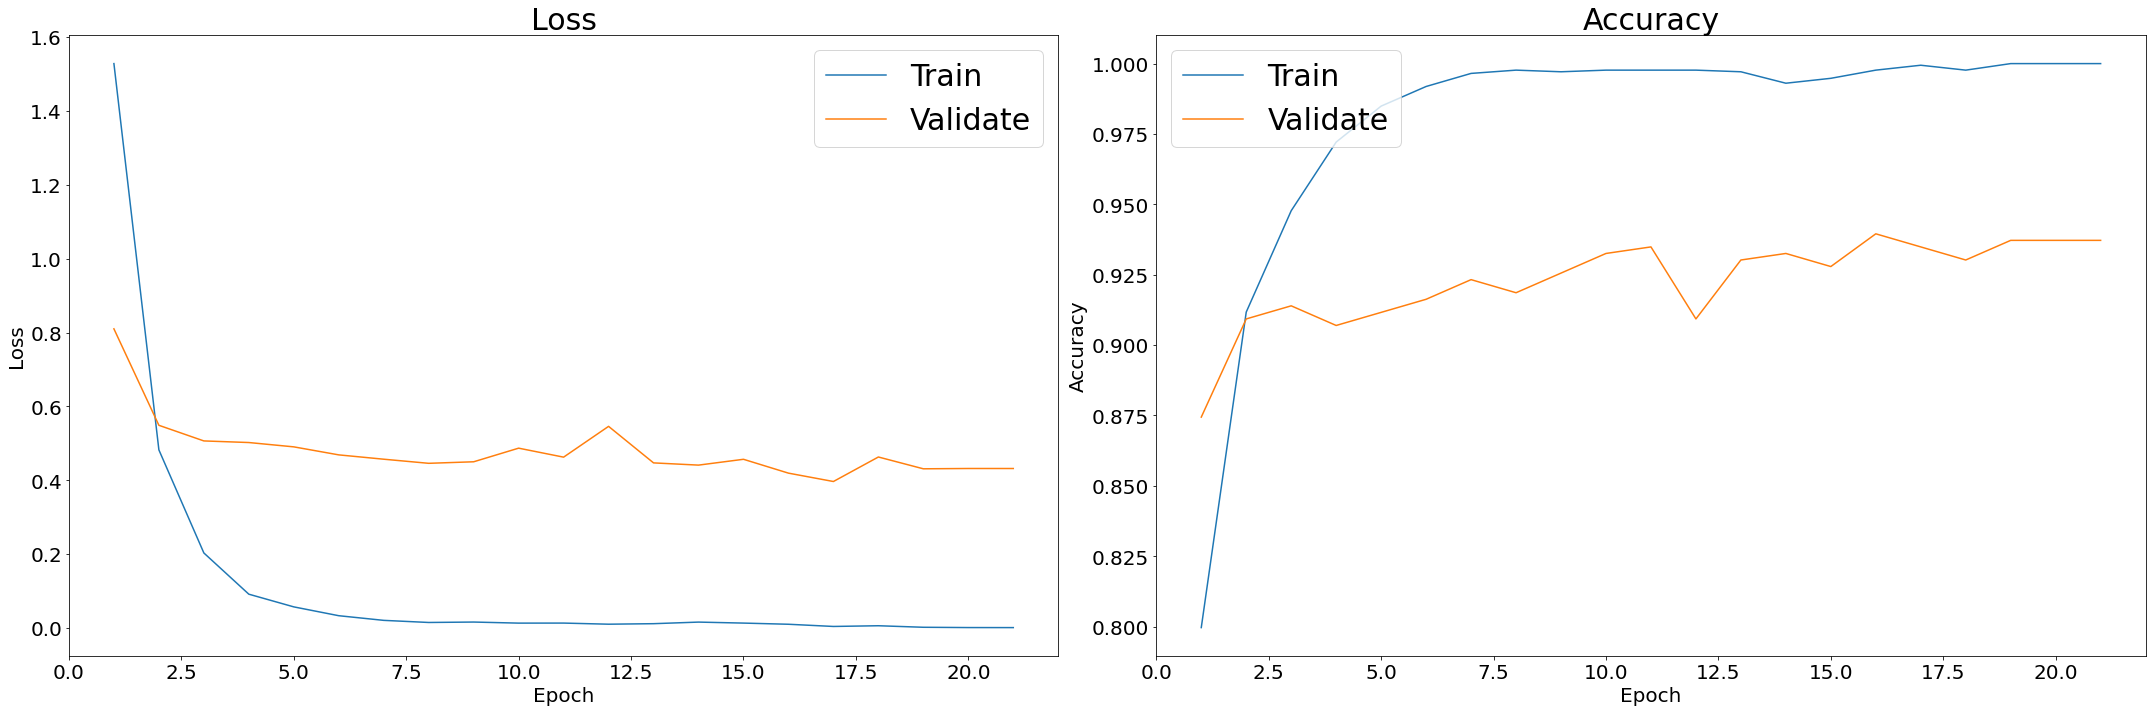

In [20]:
plot_loss_acc(history_vgg16.history, 'vgg16_loss_acc.png')

### ResNet50 Model

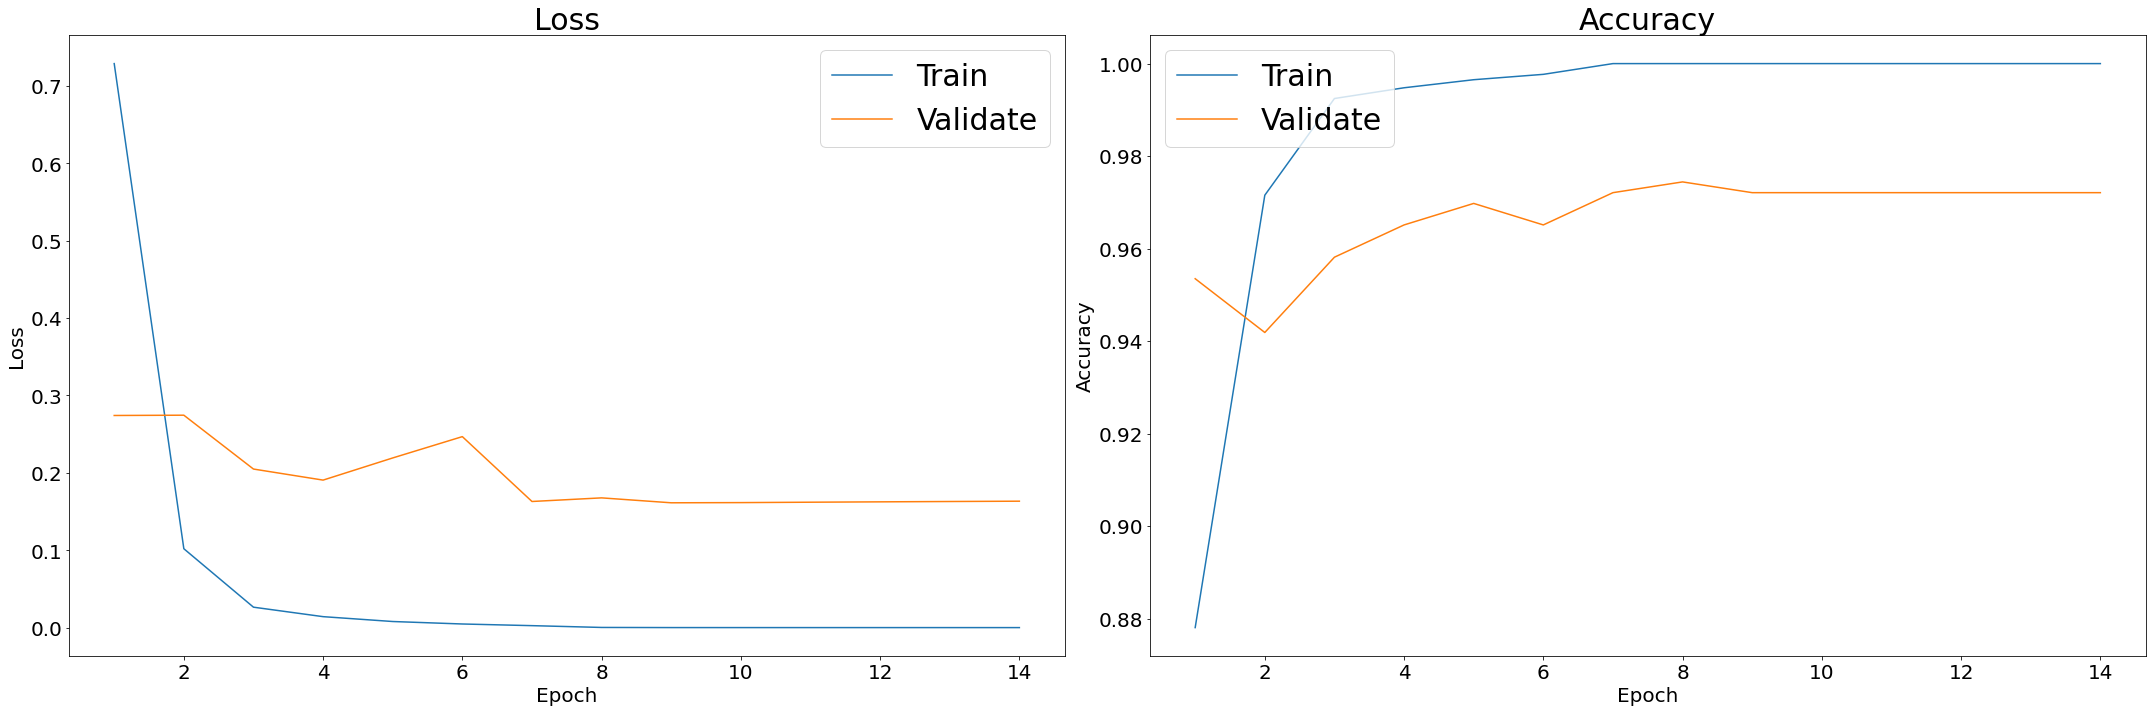

In [21]:
plot_loss_acc(history_resnet50.history, 'resnet50_loss_acc.png')